FONCTIONS

In [2]:
import pandas as pd
import numpy as np
import ast
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
# modèle
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#Saga et Réalisateur à inclure dans les poids
#Tester les seuils 
#Tester le model 

In [3]:
# Transforme les str en list

def transfo_liste(x):
  if isinstance(x, str):
    return ast.literal_eval(x)
  else:
    return x

# Appliquer des poids 

def poids_numerique(X):
    colonnes_fixes = ['Date', 'Duree', 'popularity', 'moyenne_vote', 'nb_de_votes']
    
    # Dictionnaire des poids pour ces colonnes
    poids_fixes_dict = {
        'Date': 1,
        'Duree': 1,
        'popularity': 0,
        'moyenne_vote': 0,
        'nb_de_votes': 1,
    }

    # Appliquer les poids aux colonnes numériques existantes
    for col in colonnes_fixes:
        if col in X.columns:
            X[col] *= poids_fixes_dict[col]
    
    return X

def poids_liste(X):
    poids_variables_dict = {
        'Genres': 5,
        'production_companies_name': 0,
        'Acteurs': 1,
        'Realisateur': 1
    }

    # Appliquer les poids aux colonnes contenant des listes
    for col in X.columns:
        for keyword, poids in poids_variables_dict.items():
            if keyword in col:  # Vérifier si le nom de la colonne contient un des mots-clés
                X[col] *= poids
    
    return X


# FONCTION 1
def encodage_X(X, type):
    from sklearn.preprocessing import StandardScaler, MinMaxScaler

    # Index original pour réassignation si nécessaire
    index = X.index

    # Séparation des colonnes numériques et catégoriques
    X_num = X.select_dtypes('number')
    X_str = X.select_dtypes('object')

    # Scaler pour les colonnes numériques
    if type == 'standard':
        SN = StandardScaler()
    else:
        SN = MinMaxScaler()

    # Transformation des colonnes numériques
    X_num_scaled = pd.DataFrame(SN.fit_transform(X_num), columns=X_num.columns, index=index)


    # Encodage des colonnes textuelles spécifiées
    seuils = {
        'Genres': 25,                                 # 25 = 32 colonne 
        'production_companies_name': 100,                        # 100 = 92 colonne
        'Acteurs': 25                                        #50 = 253 colonne    25 = 1403 colonne
    }
    liste = ['Genres', 'production_companies_name', 'Acteurs']
    X_list = pd.DataFrame(index=index)

    for col in liste:
        if col in X_str.columns:
            value_counts = {}
        
            # Compte les occurrences de chaque valeur dans la colonne
            for sublist in X_str[col].dropna():
                if isinstance(sublist, list):
                    for value in sublist:
                        value_counts[value] = value_counts.get(value, 0) + 1

        # Récupère le seuil spécifique pour la colonne, sinon utilise une valeur par défaut (ex. : 50)
            seuil = seuils.get(col, 50)
        
            # Ajout des colonnes binaires pour les valeurs dépassant le seuil
            for value, count in value_counts.items():
                if count >= seuil:
                    X_list[f"{col}_{value}"] = X_str[col].apply(
                        lambda x: value in x if isinstance(x, list) else False
                    )

            

    # Gestion de la colonne 'Saga'
    if 'Saga' in X.columns:
        seuil_saga = 20  # Définir le seuil pour les sagas
        saga_counts = X['Saga'].value_counts()

        # Filtrer les sagas qui apparaissent au moins 3 fois
        sagas_frequentes = saga_counts[saga_counts >= seuil_saga].index

        # Créer un DataFrame pour les sagas fréquentes
        X_saga = pd.DataFrame(index=X.index)

        # Ajouter une colonne binaire pour chaque saga fréquente
        for saga in sagas_frequentes:
            X_saga[f"Saga_{saga}"] = X['Saga'].apply(
                lambda x: 1 if x == saga else 0
            )
    else:
        # Si la colonne n'existe pas, on initialise un DataFrame vide
        X_saga = pd.DataFrame(index=X.index)


    # Gestion de la colonne 'Realisateur'
    if 'Realisateur' in X.columns:
        seuil_realisateur = 15                                       # 15 = 532 colonne
        Realisateur_counts = X['Realisateur'].value_counts()

        # Filtrer les réalisateurs qui apparaissent au moins 3 fois
        realisateurs_frequents = Realisateur_counts[Realisateur_counts >= seuil_realisateur].index

        # Créer un DataFrame pour les réalisateurs fréquents
        X_Realisateur = pd.DataFrame(index=X.index)

        # Ajouter une colonne binaire pour chaque réalisateur fréquent
        for realisateur in realisateurs_frequents:
            X_Realisateur[f"Realisateur_{realisateur}"] = X['Realisateur'].apply(
                lambda x: 1 if x == realisateur else 0
            )
    else:
        # Si la colonne n'existe pas, on initialise un DataFrame vide
        X_Realisateur = pd.DataFrame(index=X.index)


    # Concaténation des résultats
    X_encoded = pd.concat([X_str[['tconst', 'Titre']], poids_numerique(X_num_scaled), poids_liste(X_list), poids_liste(X_Realisateur), poids_liste(X_saga)], axis=1)

    # Suppression des NaN
    X_encoded = X_encoded.dropna()

    return X_encoded, SN


# FONCTION 2

def evaluate_k(X_encoded, k_range):
    """
    Évalue différentes valeurs de k en utilisant la somme des distances aux voisins
    et le score de silhouette comme métriques.

    Args:
        X_encoded (DataFrame): Données normalisées
        k_range (range): Plage de valeurs de k à tester

    Returns:
        tuple: (distances moyennes, scores de silhouette)
    """
    from sklearn.metrics import silhouette_score
    from sklearn.cluster import KMeans

    avg_distances = []
    silhouette_scores = []

    for k in k_range:
        # Calcul des distances moyennes pour chaque k
        from sklearn.neighbors import NearestNeighbors
        model = NearestNeighbors(n_neighbors=k)
        model.fit(X_encoded)
        distances, _ = model.kneighbors(X_encoded)
        avg_distances.append(np.mean(distances))

        # Calcul du score de silhouette
        # Nous utilisons KMeans pour créer des clusters et évaluer la qualité
        kmeans = KMeans(n_clusters=k, random_state=42)
        clusters = kmeans.fit_predict(X_encoded)
        if k > 1:  # Le score de silhouette nécessite au moins 2 clusters
            silhouette_scores.append(silhouette_score(X_encoded, clusters))
        else:
            silhouette_scores.append(0)

    return avg_distances, silhouette_scores

# FONCTION 3

def encodage_predict(df_a_predire, SN, poids, X_encoded):
  X_num = df_a_predire.select_dtypes('number')

  X_num_SN = pd.DataFrame(SN.transform(X_num), columns=X_num.columns).reset_index(drop=True)
  X_num_SN = X_num_SN.mul(poids, axis = 1)
  
  X_encoded_predire = X_num_SN

  df_predict = X_encoded_predire

  # DataFrame vide qui a les mêmes colonnes que X_encoded
  df_final = pd.DataFrame(columns=X_encoded.columns)

  # On veut que le DataFrame ait le même nombre de lignes que df_predict
  df_final = df_final.reindex(index=df_predict.index)
  # On met tous les NaN à False
  df_final = df_final.fillna(False)

  # On parcourt chaque colonne de df_predict
  # Si la colonne est présente dans X_encoded alors on la garde
  # Sinon, on la met à False
  for column in df_predict.columns:
    if column in X_encoded.columns:
      df_final[column] = df_predict[column]

  return df_final



# FONCTION 4

def pokemons_similaires(X_encoded, film_id, model, df):

  # Vérifier si le Pokémon existe dans le dataset
  if film_id not in X_encoded['tconst'].values:
      return f"Le Pokémon {film_id} n'est pas dans le dataset."

  # Récupérer les caractéristiques du Pokémon
  film_a_predire = X_encoded[X_encoded['tconst'] == film_id]

  distances, indices = model.kneighbors(film_a_predire.drop(columns=['tconst', 'Titre']))

  return df.iloc[indices[0]].reset_index(drop=True)

In [4]:
df = pd.read_csv('BD/df_film.csv.gz', compression = 'gzip')
df = df.dropna()
df = df.drop(columns=['Region','Language', 'Saga'], axis = 1)
liste = ['Genres', 'production_companies_name', 'Acteurs']
for i in liste :
    df[i] = df[i].apply(transfo_liste)
X = df.copy()    
X_encoded, SN = encodage_X(X, 'standard')
X_encoded

C:\Users\lepor\AppData\Local\Temp\ipykernel_28980\1451365299.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_list[f"{col}_{value}"] = X_str[col].apply(
C:\Users\lepor\AppData\Local\Temp\ipykernel_28980\1451365299.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_list[f"{col}_{value}"] = X_str[col].apply(
C:\Users\lepor\AppData\Local\Temp\ipykernel_28980\1451365299.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  C

tconst                      Titre      Date     Duree  popularity  \
0      tt0035423            Kate et Léopold  0.299497  1.002524         0.0   
1      tt0041719                     Orphée -1.626889  0.686352        -0.0   
2      tt0041931                  Stromboli -1.626889 -0.947201         0.0   
3      tt0042192                     Ève... -1.626889  2.056430         0.0   
4      tt0042200  Annie, la reine du cirque -1.626889  0.422876        -0.0   
...          ...                        ...       ...       ...         ...   
60514  tt9896252       Killing Patient Zero  0.979398  0.054009        -0.0   
60515  tt9903716                     Jessie  0.979398  0.370181        -0.0   
60516  tt9904802                Enemy Lines  1.017170 -0.367553        -0.0   
60517  tt9907782           Eight for Silver  1.054943  0.633657         0.0   
60518  tt9914972             Blind Ambition  1.054943 -0.156772        -0.0   

       moyenne_vote  nb_de_votes  Genres_Fantasy  Genres_Comedy  \
0               0.0     0.874718               5              5   
1               0.0    -0.054973               5              0   
2               0.0    -0.121264               0              0   
3               0.0     1.483247               0              0   
4               0.0    -0.156423               0              5   
...             ...          ...             ...            ...   
60514           0.0    -0.217144               0              0   
60515           0.0    -0.215328               0              0   
60516          -0.0    -0.197246               0              0   
60517           0.0     0.006609               5              0   
60518           0.0    -0.217455               0              0   

       Genres_Romance  ...  Realisateur_Fernando Di Leo  \
0                   5  ...                            0   
1                   5  ...                            0   
2                   0  ...                            0   
3                   0  ...                            0   
4                   5  ...                            0   
...               ...  ...                          ...   
60514               0  ...                            0   
60515               0  ...                            0   
60516               0  ...                            0   
60517               0  ...                            0   
60518               0  ...                            0   

       Realisateur_Michael Bay  Realisateur_Ken Hughes  \
0                            0                       0   
1                            0                       0   
2                            0                       0   
3                            0                       0   
4                            0                       0   
...                        ...                     ...   
60514                        0                       0   
60515                        0                       0   
60516                        0                       0   
60517                        0                       0   
60518                        0                       0   

       Realisateur_Alain Corneau  Realisateur_Phil Rosen  \
0                              0                       0   
1                              0                       0   
2                              0                       0   
3                              0                       0   
4                              0                       0   
...                          ...                     ...   
60514                          0                       0   
60515                          0                       0   
60516                          0                       0   
60517                          0                       0   
60518                          0                       0   

       Realisateur_Mike Newell  Realisateur_Norman Tokar  \
0                            0                         0   
1        

In [6]:
df = pd.read_csv('BD/df_film.csv.gz', compression = 'gzip')
df = df.dropna()
df = df.drop(columns=['Region','Language'], axis = 1)

In [7]:
df['Saga'] = df['Titre'].str[:8].str.replace(" ", "").str.upper()

In [8]:
liste = ['Genres', 'production_companies_name', 'Acteurs']
for i in liste :
    df[i] = df[i].apply(transfo_liste)

In [9]:
X = df.copy()

IMPORTS

ACTEURS, REALISATEURS ET PRODUCTION RECURRENTS

In [8]:
# RECHERCHE DU TITRE

df_recherche = df.copy()
df_recherche['title_out_KNN'] = df_recherche['title_out_KNN'].apply(lambda x : x.lower())
recherche = 'lord rings'
recherche2 = recherche.lower().split(" ")

for element in recherche2:
    df_recherche2 = df_recherche[df_recherche['title_out_KNN'].str.contains(element)]
    df_recherche = df_recherche2

display(df_recherche[['title_out_KNN','film_id_out_KNN', 'runtime_final', 'popularity_final', 'vote_exact_final']])

title_final_out_KNN film_id_out_KNN  \
71  the lord of the rings: the fellowship of the ring       tt0120737   
72              the lord of the rings: the two towers       tt0167261   
73      the lord of the rings: the return of the king       tt0167260   

    runtime_final  popularity_final  vote_exact_final  
71          179.0            74.296             8.396  
72          179.0            62.983             8.378  
73          201.0            65.571             8.473

In [5]:
X[X['Titre'].str.contains('30 ans')]

tconst                     Titre    Date  Duree  \
6107   tt0337563         30 ans sinon rien  2004.0   98.0   
16419  tt0084361           Mourir à 30 ans  1982.0   95.0   
41960  tt0385524  Au secours, j'ai 30 ans!  2004.0   93.0   
50176  tt0077728      Les femmes de 30 ans  1978.0  110.0   

                           Genres  popularity  moyenne_vote  nb_de_votes  \
6107   [Fantasy, Comedy, Romance]      25.796      6.308410     229528.0   
16419               [Documentary]       0.900      7.071326        258.0   
41960             [Drama, Comedy]       1.144      4.471053        266.0   
50176    [Drama, Romance, Comedy]       6.025      5.601323        756.0   

                               production_companies_name  \
6107   [Revolution Studios, Columbia Pictures, Thirte...   
16419                                                 []   
41960                                                 []   
50176  [T.S.M. Investments Limited, Films RSL, Canadi...   

                                             Description        Realisateur  \
6107   Une fillette fait un voeu le jour de son treiz...        Gary Winick   
16419  Romain Goupil records his years of militancy a...      Romain Goupil   
41960  Kathy, Tara and Yann left their Breton island ...  Marie-Anne Chazel   
50176  Andras Vajda grows up in a turbulent, war-torn...   George Kaczender   

                                                 Acteurs  
6107   [Jennifer Garner, Mark Ruffalo, Judy Greer, An...  
16419  [Alain Bureau, Pierre Goupil, Romain Goupil, S...  
41960  [Pierre Palmade, Giovanna Mezzogiorno, Nathali...  
50176  [Tom Berenger, Karen Black, Susan Strasberg, H...

In [8]:
film_id = 'tt0337563'

In [14]:
X[X['tconst'] == film_id]

tconst                      Titre    Date  Duree  \
56579  tt1630029  Avatar : La Voie de l'eau  2022.0  192.0   

                                              Genres  popularity  \
56579  [Action, Science Fiction, Fantasy, Adventure]    2857.869   

       moyenne_vote  nb_de_votes  \
56579      7.503105     523139.0   

                              production_companies_name  \
56579  [20th Century Studios, Lightstorm Entertainment]   

                                             Description    Realisateur  \
56579  Jake, Neytiri et leurs enfants vivaient paisib...  James Cameron   

                                                 Acteurs  
56579  [Sam Worthington, Zoe Saldana, Sigourney Weave...

In [17]:
# FONCTION 1

X_encoded, SN = encodage_X(X, 'standard')

# # FONCTION 2

# avg_distances, silhouette_scores = evaluate_k(X_encoded, k_range)

# # FONCTION 3

#df_final = X_encoded[X_encoded['tconst']==film_id]


C:\Users\lepor\AppData\Local\Temp\ipykernel_29068\1232142727.py:112: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_saga[f"Saga_{saga}"] = X['Saga'].apply(
C:\Users\lepor\AppData\Local\Temp\ipykernel_29068\1232142727.py:112: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_saga[f"Saga_{saga}"] = X['Saga'].apply(
C:\Users\lepor\AppData\Local\Temp\ipykernel_29068\1232142727.py:112: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

In [9]:
# # FONCTION 4

# On choisit k
k=10

model = NearestNeighbors(n_neighbors=k, metric='euclidean')
model.fit(X_encoded.drop(columns=['tconst', 'Titre']))

NearestNeighbors(metric='euclidean', n_neighbors=10)

ACTEURS ET REALISATEURS DU FILM

In [10]:
resultat = pokemons_similaires(X_encoded, film_id, model, df)
resultat

tconst                           Titre    Date  Duree  \
0   tt0337563               30 ans sinon rien  2004.0   98.0   
1   tt1058017          The Invention of Lying  2009.0  100.0   
2   tt0230030                        Endiablé  2000.0   93.0   
3   tt0821640                Hanté par ses ex  2009.0  100.0   
4   tt5783956               When We First Met  2018.0   97.0   
5   tt0207201       Ce que veulent les femmes  2000.0  127.0   
6   tt0090142                       Teen Wolf  1985.0   91.0   
7   tt0482527                  Toi, c'est moi  2006.0   95.0   
8  tt11080108  The Map of Tiny Perfect Things  2021.0   98.0   
9   tt6048930                           Naked  2017.0   96.0   

                       Genres  popularity  moyenne_vote  nb_de_votes  \
0  [Fantasy, Comedy, Romance]      25.796      6.308410     229528.0   
1  [Fantasy, Comedy, Romance]      14.012      6.397383     153493.0   
2  [Fantasy, Comedy, Romance]      20.072      6.098889     115530.0   
3  [Fantasy, Comedy, Romance]      22.873      5.803323      97811.0   
4  [Fantasy, Comedy, Romance]      12.789      6.407320      56954.0   
5  [Fantasy, Comedy, Romance]      18.800      6.498801     230257.0   
6  [Fantasy, Comedy, Romance]      48.980      6.101236      62317.0   
7  [Fantasy, Comedy, Romance]      19.367      6.206127      44235.0   
8  [Fantasy, Comedy, Romance]      11.155      6.807854      30008.0   
9  [Fantasy, Comedy, Romance]      18.826      5.416744      23130.0   

                           production_companies_name  \
0  [Revolution Studios, Columbia Pictures, Thirte...   
1  [1821 Pictures, Wintergreen Productions, Radar...   
2  [Regency Enterprises, KirchMedia, 20th Century...   
3  [Jon Shestack Productions, New Line Cinema, Pa...   
4  [Wonderland Sound and Vision, Footprint Featur...   
5                      [Paramount, Icon Productions]   
6         [Atlantic Releasing Corporation, Wolfkill]   
7  [Scion Films, Icon Entertainment International...   
8  [FilmNation Entertainment, Amazon Studios, Wis...   
9                          [Broken Road Productions]   

                                         Description     Realisateur  \
0  Une fillette fait un voeu le jour de son treiz...     Gary Winick   
1  Une comédie qui se déroule dans un monde où pe...   Ricky Gervais   
2  Elliot Richards reçoit sept voeux du diable po...    Harold Ramis   
3  En attendant le mariage de son frère, un coure...     Mark Waters   
4  Noah rencontre Avery lors d'une fête d'Hallowe...      Ari Sandel   
5  Après un accident, un cadre misogyne acquiert ...    Nancy Meyers   
6  Un lycéen ordinaire découvre que sa famille de...      Rod Daniel   
7  Des ennemis jurés échangent leur corps et en p...     Nick Hurran   
8  Deux adolescents vivent le même jour à plusieu...     Ian Samuels   
9  Nervous about finally getting married, a guy i...  Michael Tiddes   

                                             Acteurs  
0  [Jennifer Garner, Mark Ruffalo, Judy Greer, An...  
1  [Ricky Gervais, Jennifer Garner, Jonah Hill, L...  
2  [Brendan Fraser, Elizabeth Hurley, Frances O'C...  
3  [Matthew McConaughey, Jennifer Garner, Emma St...  
4  [Adam Devine, Alexandra Daddario, Shelley Henn...  
5  [Mel Gibson, Helen Hunt, Marisa Tomei, Alan Al...  
6  [Michael J. Fox, James Hampton, Susan Ursitti,...  
7  [Samaire Armstrong, Kevin Zegers, Sherry Mille...  
8  [Kathryn Newton, Kyle Allen, Jermaine Harris, ...  
9  [Marlon Wayans, Regina Hall, Dennis Haysbert, ...

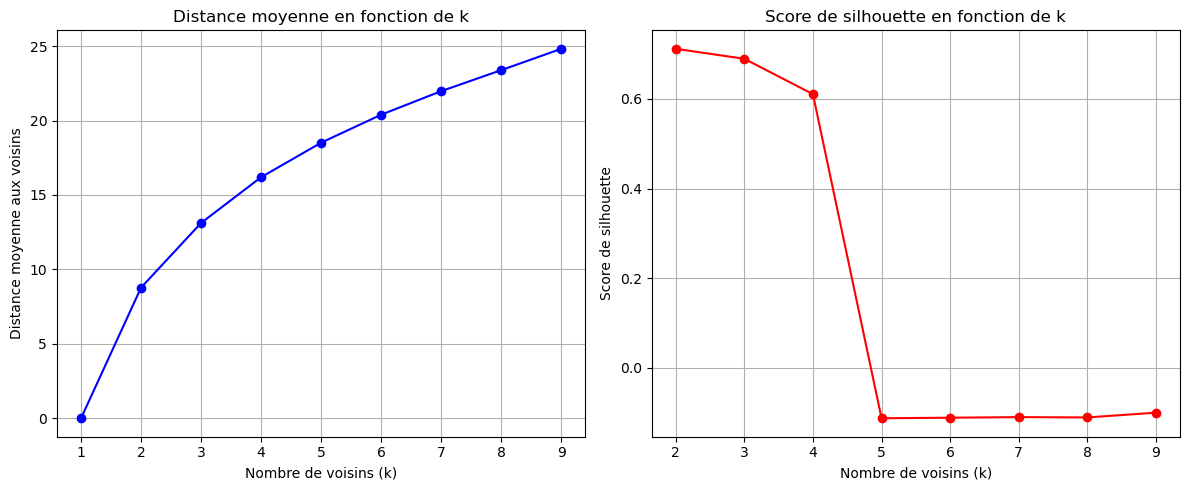

In [25]:
# Définition de la plage de k à tester

k_range = range(1,10)

# Évaluation des différentes valeurs de k
avg_distances, silhouette_scores = evaluate_k(X_encoded.drop(columns=['tconst', 'Titre']), k_range)

# Création d'une visualisation pour aider à choisir k
plt.figure(figsize=(12, 5))

# Premier graphique : Distance moyenne aux voisins
plt.subplot(1, 2, 1)
plt.plot(k_range, avg_distances, 'bo-')
plt.xlabel('Nombre de voisins (k)')
plt.ylabel('Distance moyenne aux voisins')
plt.title('Distance moyenne en fonction de k')
plt.grid(True)

# Second graphique : Score de silhouette
plt.subplot(1, 2, 2)
plt.plot(k_range[1:], silhouette_scores[1:], 'ro-')  # On commence à k=2
plt.xlabel('Nombre de voisins (k)')
plt.ylabel('Score de silhouette')
plt.title('Score de silhouette en fonction de k')
plt.grid(True)

plt.tight_layout()
plt.show()

In [14]:
#EXPORTER MODEL

import pickle

# Sauvegarder le modèle
with open('mon_modele.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
# IMPORTER MODEL

import pickle

# Charger le modèle
with open('mon_modele.pkl', 'rb') as f: #là vous mettez l'emplacement et le nom de votre fichier pkl
    model_charge = pickle.load(f)

In [211]:
# X_train, X_test, y_train, y_test = train_test_split(df_films.drop('title_out_KNN', axis=1), df_films['title_out_KNN'], test_size=0.75)

# model.fit(X_train, y_train)

# y_pred = model.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

# param_grid = {"n_neighbors": range(20)}

# # Perform grid search with cross-validation
# gscv = GridSearchCV(model, param_grid, cv=5)
# gscv.fit(X_train, y_train)


# print("Best params:", gscv.best_params_)
# print("Best cross-validation score:", gscv.best_score_)

In [ ]:
# df_films = df.copy()

# df_films['production_companies_name2'] = df_films['production_companies_name'].apply(lambda x: x.replace("[", '').replace("]", '').replace("'", ''))

# df_films['production_companies_name3'] = df_films['production_companies_name2'].apply(lambda x : x.split(','))

# tous_les_genres = set()
# tous_les_genres2 = set()

# for element in df_films['production_companies_name3']:
#   tous_les_genres.update(element)

# tous_les_genres_list = list(tous_les_genres)

# tous_les_genres_list.remove("")

# for n in range(len(tous_les_genres_list)):
#   tous_les_genres_list[n] = tous_les_genres_list[n].replace(" ","")

# tous_les_genres2_list = list(tous_les_genres2)
# tous_les_genres2_list.remove("")

# df_films['production_companies_name4'] = df_films['production_companies_name'].apply(lambda x: x.replace(" ", ''))

# new_dict = {}

# for element in tous_les_genres_list:
#     if len(df_films[df_films['production_companies_name2'].str.contains(element) == True]) >= 500:
#       new_dict.update({element : len(df_films[df_films['production_companies_name2'].str.contains(element) == True])})

# new_dict_sorted = dict(sorted(new_dict.items(), key=lambda x:x[1]))

# for genre in new_dict_sorted.keys():
#   df_films[f'production_companies_name_{genre}'] = df_films['production_companies_name4'].apply(lambda x: genre in x)

In [ ]:
# df_LN = df[df['vote_count_mean'] != 0].drop(['adult', 'production_countries', 'status', 'tagline', 'production_companies_name', 'production_companies_country', 'titleType', 'region', 'Decennie', 'genre', 'final_language', 'popularity', 'year_exact', 'runtime_exact', 'vote_exact', 'arrondi_vote_exact', 'vote_count_mean'], axis = 1)
# df_LN_drop_NA = df_LN.dropna()
# X = df_LN_drop_NA
# y = pd.DataFrame(df_LN_drop_NA)

# def encodage_X(X, type='standard'):
#   X_num = X.select_dtypes('number')
#   X_cat = X.select_dtypes(['object', 'category', 'string'])
#   # Comme ça les dates, on n'y touche pas

#   if type == 'standard':
#     from sklearn.preprocessing import StandardScaler
#     SN = StandardScaler()
#     X_num_SN = pd.DataFrame(SN.fit_transform(X_num), columns=X_num.columns)

#   else:
#     from sklearn.preprocessing import MinMaxScaler
#     SN = MinMaxScaler()
#     X_num_SN = pd.DataFrame(SN.fit_transform(X_num), columns=X_num.columns)

#   X_cat_dummies = pd.get_dummies(X_cat)
#   X_encoded = pd.concat([X_num_SN.reset_index(), X_cat_dummies.reset_index()], axis=1)

#   return X_encoded, SN

# X_encoded, SN = encodage_X(X)

# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, train_size=0.8)

# from sklearn.linear_model import LinearRegression

# modele = LinearRegression()

# modele.fit(X_train, y_train)

# print(f"Score d'entrainement {modele.score(X_train, y_train)}")
# print(f"Score de test {modele.score(X_test, y_test)}")

# df_a_predire = df_test[df_test['vote_count_mean'] == 0].drop(['isOriginalTitle', 'ordering', 'film_id', 'id', 'revenue', 'budget', 'backdrop_path', 'homepage', 'overview', 'poster_path', 'status', 'tagline', 'video', 'titleType', 'types', 'attributes'], axis = 1)
# df_a_predire = df_a_predire.drap('vote_count_mean', axis = 1)
# df_quelonveutpredire = df_a_predire.dropna()

# def encodage_predict(df_a_predire):
#   X_num = df_a_predire.select_dtypes('number')
#   X_cat = df_a_predire.select_dtypes(['object', 'category', 'string'])

#   X_num_SN = pd.DataFrame(SN.transform(X_num), columns=X_num.columns).reset_index(drop=True)

#   X_cat_dummies = pd.get_dummies(X_cat).reset_index(drop=True)
#   X_encoded_predire = pd.concat([X_num_SN.reset_index(), X_cat_dummies.reset_index()], axis=1)

#   df_predict = X_encoded_predire

#   # DataFrame vide qui a les mêmes colonnes que X_encoded
#   df_final = pd.DataFrame(columns=X_encoded.columns)

#   # On veut que le DataFrame ait le même nombre de lignes que df_predict
#   df_final = df_final.reindex(index=df_predict.index)
#   # On met tous les NaN à False
#   df_final = df_final.fillna(False)

#   # On parcourt chaque colonne de df_predict
#   # Si la colonne est présente dans X_encoded alors on la garde
#   # Sinon, on la met à False
#   for column in df_predict.columns:
#     if column in X_encoded.columns:
#       df_final[column] = df_predict[column]

#   return df_final

# df_pour_prediction = encodage_predict(df_quelonveutpredire)

# df_quelonveutpredire['prediction'] = modele.predict(df_pour_prediction)
# df_quelonveutpredire
